We trying

Research Diary: https://drive.google.com/open?id=1zBXLaCameGhHj8RbXeGkep6_gZnUAiAnhGrVE1aEr-4

In [107]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from copy import deepcopy
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

In [108]:
# Force divider function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

# FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

# Total impulse function for a single matrix of data 
# Iterates over data and computes the total impulse for all sensors over time
def impulse(data_matrix): 
    fsr_data = data_matrix
    impulse = 0
    for col in range(0, 12):
        single_FSR = data_matrix[:,col]
        for i in range(0, 1000):
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef
    return impulse 

# Return a numpy array containing the differential between consecutive elements (approximation of slope) 
# in a given data array
def slope(dataVector):
    dydx = []
    for i in range(1, len(dataVector)):
        diff = dataVector[i] - dataVector[i-1]
        dydx.append(diff)
    finalDiff = dataVector[i] - dataVector[i-1] # Added just to make the final array the proper dimensions 
    dydx.append(finalDiff)
    return np.array(dydx)

# Return a numpy array containing the value and index of the largest magnitude value in given data array (first instance)
def largest(dataVector):
    val = max(abs(dataVector))
    ind = 0
    for k in dataVector:
        if abs(k) == val:
            return np.array([val, ind])
        else:
            ind += 1

# Mean function
def mean(dataVec):
    return sum(dataVec) / len(dataVec)

# Standard Deviation
def sd(dataVec):
    avg = mean(dataVec)
    tot = 0
    for elem in dataVec:
        tot = tot + (elem - avg)*(elem - avg)
    return math.sqrt(tot / len(dataVec))

In [109]:
# Labels
    # Fall = 1
    # Impact = 2
    # Nothing = 3
    # Squeeze = 4
    
# Add Fall data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/fall"
numbers = np.arange(1,15)
fsrData = []
accelData = []
totData = []
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrFall = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelFall = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totFall = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrFall = fsrFall.to_numpy()
    accelFall = accelFall.to_numpy()
    totFall = totFall.to_numpy()
    fsrData.append(fsrFall)
    accelData.append(accelFall)
    totData.append(totFall)

    
# Add Impact data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/impact"
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrImp = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                "FSR_12"]]
    accelImp = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totImp = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrImp = fsrImp.to_numpy()
    accelImp = accelImp.to_numpy()
    totImp = totImp.to_numpy()
    fsrData.append(fsrImp)
    accelData.append(accelImp)
    totData.append(totImp)

    
# Add Nothing data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/nothing"
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelNoth = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrNoth = fsrNoth.to_numpy()
    accelNoth = accelNoth.to_numpy()
    totNoth = totNoth.to_numpy()
    fsrData.append(fsrNoth)
    accelData.append(accelNoth)
    totData.append(totNoth)
    
# Add Squeeze data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV2/squeeze"
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelSqueeze = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrSqueeze = fsrSqueeze.to_numpy()
    accelSqueeze = accelSqueeze.to_numpy()
    totSqueeze = totSqueeze.to_numpy()
    fsrData.append(fsrSqueeze)
    accelData.append(accelSqueeze)
    totData.append(totSqueeze)



In [110]:
# Convert fsr data to Newtons
placeHold = []
for m in fsrData:
    m = force_divider(FSR_model(m *5/1023))  
    placeHold.append(m)

for k in totData:
    k[:, 0:12] = force_divider(FSR_model(k[:, 0:12] *5/1023))

fsrData = placeHold


In [111]:
# Smoothing out fsr data

fsrRefined = deepcopy(fsrData)

for test in fsrRefined:
    for k in range(0, 12):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       


In [112]:
# Smoothing out acceleration data
accelRefined = deepcopy(accelData)

for test in accelRefined:
    for k in range(0, 3):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       


In [113]:
# Smoothing out total Data
totRefined = deepcopy(totData)

for test in totRefined:
    for k in range(0, 15):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       


In [114]:
# Generate slope vectors for accel data
accelSlopes = []
for i in range(0, 56):
    accelVec = slope(accelRefined[i])
    accelSlopes.append(accelVec)

In [115]:
# Clean acceleration slope data
slopeRefined = deepcopy(accelSlopes)

for test in slopeRefined:
    for k in range(0, 3):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)  


In [116]:
# Total data + accelerometer slopes
totSlope = []
for i in range(0, 56):
    combinedData = np.append(totRefined[i], slopeRefined[i], axis = 1)
    totSlope.append(combinedData)


In [117]:
# Labels!

l1 = np.ones((14,), dtype=int) 
l2 = 2*np.ones((14,), dtype=int) 
l3 = 3*np.ones((14,), dtype=int)
l4 = 4*np.ones((14,), dtype=int)
labels = np.concatenate((l1, l2, l3, l4), axis=0)


# Prepare data for algorithms
nsamples, nx, ny = np.shape(totSlope)
reformated_data = np.reshape(totSlope,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)

In [118]:
# K-Fold Cross Validation

X = reformated_data
y = labels
skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X, y)

4

In [119]:
# Gaussian Naive-Bayes

for train_index, test_index in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    nb = GaussianNB().fit(X_train, y_train)
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    print(nb.predict_proba(X_test))
    print("\n")

1.0
Predicted labels = [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
Correct labels =   [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


0.8125
Predicted labels = [1 1 2 1 2 2 2 2 3 3 3 3 4 2 2 4]
Correct labels =   [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[[1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [5.02356563e-303 1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000

In [120]:
# Comparing labels for ROC Curve
twoClasses = totSlope[28:42] + totSlope[42:56]
twoLabels = np.concatenate((l1, l2), axis = 0)

nsamples, nx, ny = np.shape(twoClasses)
reformated_data = np.reshape(twoClasses,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# # Generate ROC Curve
# probs = nb.predict_proba(X_test)[:, 0]
# false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, probs, pos_label=1)

# plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
#          where='post')
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('Sensitivity')
# plt.title('Fall vs. Impact ROC Curve')

1.0
Predicted labels = [1 2 2 2 1 1 2]
Correct labels =   [1 2 2 2 1 1 2]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]




In [122]:
# Random Forest

for train_index, test_index in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    nb = RandomForestClassifier(n_estimators = 400).fit(X_train, y_train)
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    print(nb.predict_proba(X_test))
    print('\n')

0.875
Predicted labels = [1 1 1 1 2 2 1 3 3 3 3 3 4 4 4 4]
Correct labels =   [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[[0.545  0.0625 0.39   0.0025]
 [0.5275 0.085  0.375  0.0125]
 [0.605  0.0875 0.2975 0.01  ]
 [0.51   0.0775 0.41   0.0025]
 [0.195  0.5025 0.285  0.0175]
 [0.2775 0.4025 0.25   0.07  ]
 [0.3675 0.365  0.2225 0.045 ]
 [0.2475 0.32   0.405  0.0275]
 [0.1725 0.0725 0.735  0.02  ]
 [0.2575 0.0975 0.615  0.03  ]
 [0.3525 0.0675 0.5775 0.0025]
 [0.3025 0.045  0.6525 0.    ]
 [0.055  0.08   0.145  0.72  ]
 [0.0225 0.025  0.025  0.9275]
 [0.025  0.0175 0.0525 0.905 ]
 [0.01   0.0025 0.0275 0.96  ]]


1.0
Predicted labels = [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
Correct labels =   [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[[0.5475 0.1425 0.2875 0.0225]
 [0.545  0.11   0.33   0.015 ]
 [0.4575 0.14   0.275  0.1275]
 [0.63   0.065  0.27   0.035 ]
 [0.19   0.48   0.24   0.09  ]
 [0.22   0.45   0.2925 0.0375]
 [0.195  0.59   0.1525 0.0625]
 [0.355  0.3725 0.205  0.0675]
 [0.3525 0.0625 0.5525 0.0325]


0.7857142857142857
Predicted labels = [1 2 1 1 1 1 1 1 1 1 1 1 1 1]
Correct labels =   [1 1 1 2 1 1 1 1 1 1 1 1 1 2]
[[1.  0. ]
 [0.3 0.7]
 [0.9 0.1]
 [0.6 0.4]
 [1.  0. ]
 [0.9 0.1]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]
 [1.  0. ]
 [0.8 0.2]
 [0.7 0.3]
 [0.6 0.4]]


AUC: 0.9166666666666667


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


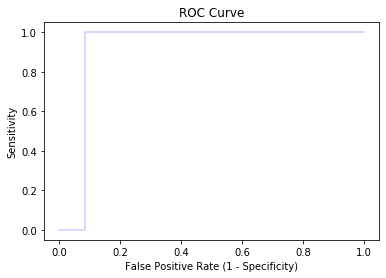

In [123]:
# Comparing labels for ROC Curve
twoLabels = np.concatenate((l1, l2, l1, l1), axis = 0)

nsamples, nx, ny = np.shape(totSlope)
reformated_data = np.reshape(totSlope,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = RandomForestClassifier().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
probs = nb.predict_proba(X_test)[:, 0]
prob2 = nb.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.title('ROC Curve')

print("AUC: " + str(roc_auc_score(y_test, prob2)))

In [23]:
# Looping over various parameters to systematically check AUC
aucArray = []
for param in np.arange(1000, 5000, 10):
    aucSubArray = []
    for i in range(0, 5):
        twoLabels = np.concatenate((l1, l1, l2, l1), axis = 0)

        nsamples, nx, ny = np.shape(totSlope)
        reformated_data = np.reshape(totSlope,(nsamples, nx*ny))
        [X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

        nb = RandomForestClassifier(max_depth = param).fit(X_train, y_train)
        y_pred = nb.predict(X_test)

        # Generate ROC Curve
        prob2 = nb.predict_proba(X_test)[:, 1]
        false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

        aucSubArray.append(roc_auc_score(y_test, prob2))
    aucArray.append([param, mean(aucSubArray)])
print(np.shape(aucArray))

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

(400, 2)


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
df = pd.DataFrame(aucArray, columns = ['Max Depth', 'AUC Scores'])
df.to_excel('C:/Users/alber/Desktop/BEST/Tensegrity-HRI/AUC_MD_3_ext.xlsx', sheet_name = 'Sheet1')

In [124]:
# PCA on total data

pcaTot = deepcopy(totRefined)
pca = PCA(n_components = 1)

for i in range(0, 56):
    pcaTot[i] = pca.fit_transform(pcaTot[i])

In [125]:
# Run script on data

# Prepare data for algorithms
nsamples2, nx2, ny2 = np.shape(pcaTot)
reformated_data2 = np.reshape(pcaTot,(nsamples2, nx2*ny2))
[X_train2, X_test2, y_train2, y_test2] = train_test_split(reformated_data2, labels, random_state=0)

# K-Fold Cross Validation
X2 = reformated_data2
y2 = labels
skf2 = StratifiedKFold(n_splits=4)
skf2.get_n_splits(X2, y2)

# Gaussian Naive-Bayes
for train_index, test_index in skf2.split(X2, y2):
    X_train, X_test, y_train, y_test = X2[train_index], X2[test_index], y2[train_index], y2[test_index]
    nb = GaussianNB().fit(X_train, y_train)
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    print(nb.predict_proba(X_test))
    print('\n')

0.75
Predicted labels = [1 1 1 2 2 2 4 2 3 3 3 3 2 2 4 4]
Correct labels =   [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[[1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 2.33538187e-024]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 2.36805664e-320]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 

0.7142857142857143
Predicted labels = [2 2 1 2 1 1 2]
Correct labels =   [1 2 2 2 1 1 2]
[[0.00000000e+000 1.00000000e+000]
 [4.60304128e-161 1.00000000e+000]
 [1.00000000e+000 6.76317775e-206]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [4.76000015e-096 1.00000000e+000]]


AUC: 0.7916666666666667


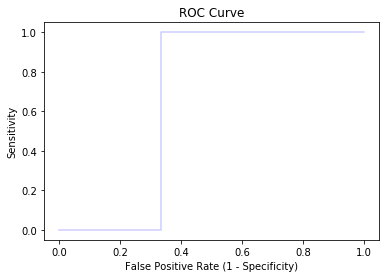

In [126]:
# Comparing labels for ROC Curve
twoClasses = pcaTot[14:28] + pcaTot[42:56]
twoLabels = np.concatenate((l1, l2), axis = 0)

nsamples, nx, ny = np.shape(twoClasses)
reformated_data = np.reshape(twoClasses,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
probs = nb.predict_proba(X_test)[:, 0]
prob2 = nb.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.title('ROC Curve')

print("AUC: " + str(roc_auc_score(y_test, prob2)))

In [127]:
# Random Forest
for train_index, test_index in skf2.split(X2, y2):
    X_train, X_test, y_train, y_test = X2[train_index], X2[test_index], y2[train_index], y2[test_index]
    nb = RandomForestClassifier().fit(X_train, y_train)
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    print(nb.predict_proba(X_test))
    print('\n')

0.75
Predicted labels = [1 1 1 1 2 4 4 2 3 3 3 3 1 1 4 4]
Correct labels =   [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[[0.6 0.1 0.1 0.2]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [0.5 0.1 0.2 0.2]
 [0.  0.6 0.1 0.3]
 [0.  0.4 0.  0.6]
 [0.1 0.3 0.1 0.5]
 [0.  0.5 0.1 0.4]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.9 0.1]
 [0.6 0.3 0.  0.1]
 [0.5 0.2 0.  0.3]
 [0.  0.  0.3 0.7]
 [0.2 0.  0.2 0.6]]


0.875
Predicted labels = [1 1 1 1 2 2 2 4 3 3 3 3 4 4 1 4]
Correct labels =   [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
[[1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [0.  0.5 0.2 0.3]
 [0.  0.5 0.1 0.4]
 [0.1 0.6 0.2 0.1]
 [0.1 0.2 0.  0.7]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.2 0.  0.8]
 [0.  0.2 0.  0.8]
 [0.3 0.3 0.1 0.3]
 [0.  0.1 0.3 0.6]]


0.9166666666666666
Predicted labels = [1 1 1 2 2 2 3 3 3 4 2 4]
Correct labels =   [1 1 1 2 2 2 3 3 3 4 4 4]
[[1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0.

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9285714285714286
Predicted labels = [1 1 1 2 1 1 1 1 1 1 1 1 1 1]
Correct labels =   [1 1 1 2 1 1 1 1 1 1 1 1 1 2]
[[0.95625 0.04375]
 [1.      0.     ]
 [1.      0.     ]
 [0.26125 0.73875]
 [0.9975  0.0025 ]
 [1.      0.     ]
 [1.      0.     ]
 [0.57625 0.42375]
 [0.9375  0.0625 ]
 [1.      0.     ]
 [0.9975  0.0025 ]
 [0.98625 0.01375]
 [1.      0.     ]
 [0.52    0.48   ]]


AUC: 1.0


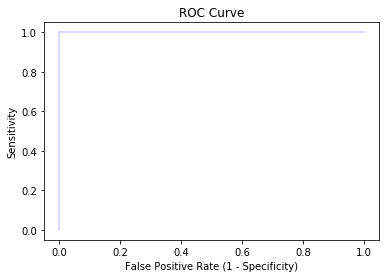

In [128]:
# Comparing labels for ROC Curve
twoLabels = np.concatenate((l1, l2, l1, l1), axis = 0)

nsamples, nx, ny = np.shape(pcaTot)
reformated_data = np.reshape(pcaTot,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = RandomForestClassifier(n_estimators = 800).fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
prob2 = nb.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.title('ROC Curve')

print("AUC: " + str(roc_auc_score(y_test, prob2)))

In [93]:
# Looping over various parameters to systematically check AUC
twoLabels = np.concatenate((l1, l1, l1, l2), axis = 0)

nsamples, nx, ny = np.shape(pcaTot)
reformated_data = np.reshape(pcaTot,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

aucArray = []
for param in np.arange(500, 1010, 10):
    aucSubArray = []
    for i in range(0, 5):
        nb = RandomForestClassifier(max_depth = param).fit(X_train, y_train)
        y_pred = nb.predict(X_test)

        # Generate ROC Curve
        prob2 = nb.predict_proba(X_test)[:, 1]
        false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

        aucSubArray.append(roc_auc_score(y_test, prob2))
    aucArray.append([param, mean(aucSubArray)])
print(np.shape(aucArray))

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

(51, 2)


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

In [94]:
df = pd.DataFrame(aucArray, columns = ['Num Trees', 'AUC Scores'])
df.to_excel('C:/Users/alber/Desktop/BEST/Tensegrity-HRI/AUC_MD_4_ext.xlsx', sheet_name = 'Sheet1')